# Amazon Reviews - Sentiment Model Experimentation

### Imports

In [1]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import pandas as pd
import subprocess
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import gzip
from io import BytesIO
import zipfile
import random
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report
import nltk

### Configs and Global Vars

In [28]:
configs = {
    'aws_region' :  'us-east-1',
    'bucket_name': 'demos-amazon-reviews',
    'prefix' : 'preprocessed_reviews', #only use this if you want to have your files in a folder 
    'index_key' : 'review_date_str',
    'file_extension' : '.parquet'
   
}

global_vars = {}

### Environment Setup

Setting up the environment involves ensuring all the corret session and IAM roles are configured. We also need to ensure the correct region and bucket is made available.

In [29]:
def setup_env(configs, global_vars):
    
    sess = sagemaker.Session()
    
    role = get_execution_role()

    AWS_REGION = configs['aws_region']
    s3 = boto3.resource('s3')

    s3_bucket = s3.Bucket(configs['bucket_name'])

    if s3_bucket.creation_date == None:
    # create S3 bucket because it does not exist yet
        print('Creating S3 bucket {}.'.format(bucket))
        resp = s3.create_bucket(
            ACL='private',
            Bucket=bucket
        )
    else:
        print('Bucket already exists')
        
    global_vars['role'] = role
    global_vars['sess'] = sess
    global_vars['s3'] = s3
    global_vars['s3_bucket'] = s3_bucket
    
    return global_vars

global_vars = setup_env(configs, global_vars)

Bucket already exists


### Create Data Manifest

At this step, we need to create an index of all the files we're going to be using for this experiment and model building. Now, we don't want to download all of the data at once, or we're going to cause a lot of I/O activity for your Notebook Instance. 

What we're going to do is first create a path index to where the files live on S3. From there, we can do some sampling to get to see what the data looks like, do some basic sampling stats on the data, to get a better handle on how we should build a model, and then move to using all the data to build a robust model!

In [30]:
def create_dataset_manifest(configs, global_vars):
    
    interval_printer_idx = 100000
    idx = 0
    
    conn = global_vars['s3_bucket']
    file_format = configs['file_extension']

    manifest = []    
    for file in conn.objects.all():
        path = file.key
        if (file_format in path):
            relative_path = path.replace(configs['prefix'],'')
            man = {'idx':idx, 'path':relative_path, 'path_with_prefix':path}
            manifest.append(man)  
            idx += 1
        if (idx % interval_printer_idx) == 0:
            print('Processed {} files'.format(idx))
    print('Training Dataset Size {}'.format(len(manifest)))
    return manifest
            
manifest = create_dataset_manifest(configs, global_vars)   
    

Processed 100000 files
Processed 200000 files
Processed 300000 files
Processed 400000 files
Processed 500000 files
Processed 600000 files
Processed 700000 files
Processed 800000 files
Processed 900000 files
Processed 1000000 files
Processed 1100000 files
Processed 1200000 files
Processed 1300000 files
Processed 1400000 files
Processed 1500000 files
Training Dataset Size 1564126


### Explore Manifest Stats

Given that we know what the index of our manifest is partitioned by, let's do some simple stats to learn more about our manifest so we can make some informed decisions for our sampling and modelling

Total folders 235
Total Files 1564126
Date with most files 2015-08
Date with fewest files 1995-12

        once we examine the distribution, we can determine how we are going to sample our manifest to get a better 
        understanding of our reviews. Remember the plot only represents the number of files in each folder. but
        there is a linear relationship between the number of files, and the number of reviews per bin


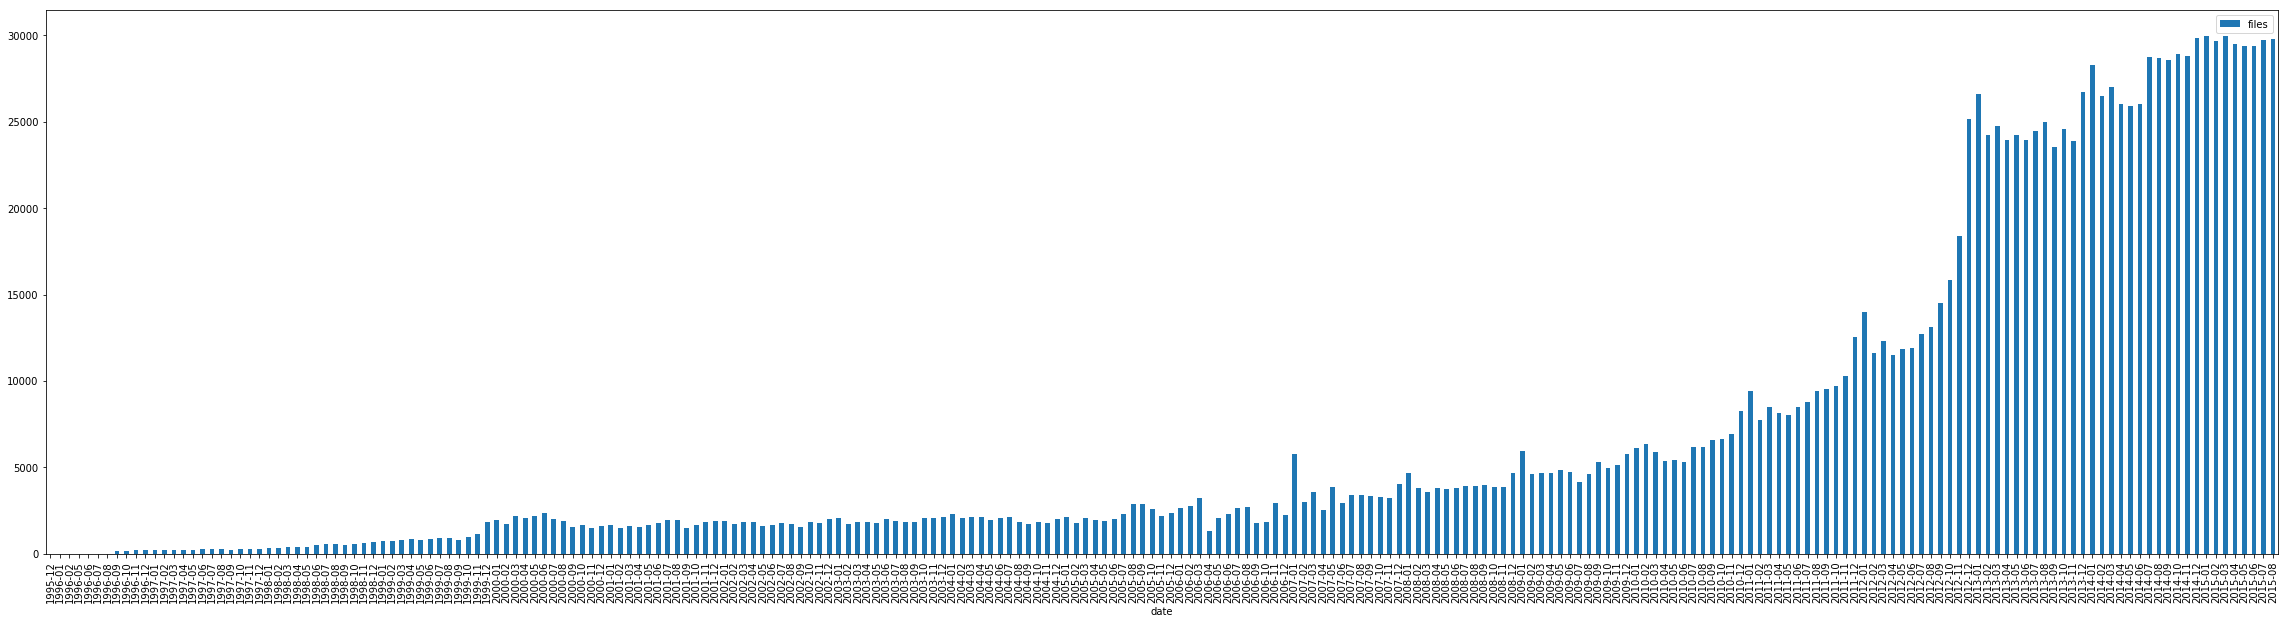

In [60]:
def generate_manifest_statistics(configs, manifest):
    
    date_cnt = {}
    stats = {}
    index_key = configs['index_key']+'='
    for entry in manifest:
        
        date = entry['path'].split('/')[1].replace(index_key,'')
        if date in date_cnt:
            date_cnt[date] = date_cnt[date] + 1
        else:
            date_cnt[date] = 1
    
    tmp = []
    for date, cnt in date_cnt.items():
        itm = {'date':date, 'files':cnt}
        tmp.append(itm)
    df_stats = pd.DataFrame(tmp)
    df_stats.plot.bar(x='date', y='files', figsize=(40,10))  
    
    print('Total folders {}'.format(df_stats.shape[0]))
    print('Total Files {}'.format(manifest_df_stats.sum()['files']))
    print('Date with most files {}'.format(manifest_df_stats.max()['date']))
    print('Date with fewest files {}'.format(manifest_df_stats.min()['date']))

    notes = '''
        once we examine the distribution, we can determine how we are going to sample our manifest to get a better 
        understanding of our reviews. Remember the plot only represents the number of files in each folder. but
        there is a linear relationship between the number of files, and the number of reviews per bin'''
    
    print(notes)
    
    return df_stats
    
manifest_df_stats = generate_manifest_statistics(configs, manifest)    

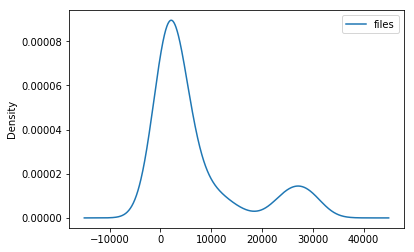

In [66]:
manifest_df_stats.plot.kde()

### Generate Sample Manifest

Now we're going to generate a sample of our dataset to ensure that we get some views of how the data looks and feels across the years.

In [ ]:
def generate_sample_manifest(manifest, sample_size):
    
    